# IMPORT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from ipynb.fs.full.BoxPlot import box_plot, box_plot_compare

# METHOD

### Euclidean Distance(For Numpy Array)

In [2]:
def np_euclidean(e1,e2):
    return math.sqrt(math.fsum(list(map(lambda x: x**2 ,e1-e2))))

### Generate Data and Results for each File

In [3]:
def read_all_lines(file) :
    with open(file, 'rt') as fd:
        convert = [e.split() for e in fd.readlines()]
        all_data = []
        all_results = []
        for line in convert:
            data = line
            result = data.pop(-1)
            all_data.append(data)
            all_results.append(result)
            
        float_data = []
        for element in all_data:
            float_data.append([float(e) for e in element])
        float_data = np.array(float_data)
        all_results = np.array(all_results)
        
        normalized_data = []
        for element in float_data:
            mean = math.fsum(element)/len(element)
            std = math.sqrt(sum((element-mean)**2)/(len(element)-1))
            normalized_data.append((element - mean)/std)
        normalized_data = np.array(normalized_data)
        return normalized_data, all_results

### Dynamic Time Warping

In [4]:
def dtw_distance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

### DBA

In [5]:
from __future__ import division
from functools import reduce


__author__ ="Francois Petitjean"

def performDBA(series, n_iterations=10):
    n_series = len(series)
    max_length = reduce(max, map(len, series))

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat)
    center = series[medoid_ind]

    for i in range(0,n_iterations):
        center = DBA_update(center, series, cost_mat, path_mat, delta_mat)

    return center

def approximate_medoid_index(series,cost_mat,delta_mat):
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)

    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in indices:
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat):
    s_len = len(s)
    t_len = len(t)
    length = len(s)
    fill_delta_mat_dtw(s, t, delta_mat)
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <=left):
                if(diag<=top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat):
    slim = delta_mat[:len(center),:len(s)]
    np.subtract.outer(center, s,out=slim)
    np.square(slim, out=slim)

def DBA_update(center, series, cost_mat, path_mat, delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    n_elements = np.array(np.zeros(center.shape), dtype=int)
    center_length = len(center)
    for s in series:
        s_len = len(s)
        fill_delta_mat_dtw(center, s, delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[i] += s[j]
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[i] += s[j]
        n_elements[i] += 1

    return np.divide(updated_center, n_elements)

### Calculate F1 Score

In [6]:
def score(test_data,test_results,mrcp_avg,noise_avg):
    e_results = list()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for each_test_data in test_data:
        e_class = None
        min_dist = float('inf')
        for avg in mrcp_avg:
            dist = dtw_distance(each_test_data, avg) 
            if dist < min_dist:
                min_dist = dist
                e_class = 'MRCP'
        for avg in noise_avg:
            dist = dtw_distance(each_test_data, avg) 
            if dist < min_dist:
                min_dist = dist
                e_class = 'Noise'
        e_results.append(e_class)
    e_results = np.array(e_results)
    for i in range(len(test_data)):
        if e_results[i] == 'MRCP' and test_results[i] == 'MRCP' :
            TP += 1
        elif e_results[i] == 'MRCP' and test_results[i] == 'Noise' :
            FP += 1
        elif e_results[i] == 'Noise' and test_results[i] == 'MRCP' :
            FN += 1
        elif e_results[i] == 'Noise' and test_results[i] == 'Noise' :
            TN += 1
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)*100
    f1_score = (2*precision*recall)/(precision+recall)*100
    return accuracy,f1_score

# IMPORT DATA

### Generate Data and Results for each File

In [49]:
data , results = read_all_lines('training data/participant_1.txt')
test_data , test_results = read_all_lines('test data/participant_1.txt')
print('Data: ',data[:5])
len(test_data[0])

230 117 347


### Split data to MRCP data set and Noise data set

In [41]:
mrcp_data = list()
noise_data = list()
mrcp_result = list()
noise_result = list()

for each_data, each_result in zip(data,results):
    if each_result == 'MRCP':
        mrcp_data.append(each_data)
        mrcp_result.append(each_result)
    else:
        noise_data.append(each_data)
        noise_result.append(each_result)
        
mrcp_data = np.array(mrcp_data)
noise_data = np.array(noise_data)
mrcp_results = np.array(mrcp_result)
noise_results = np.array(noise_result)

187 160


### Subclass Splitting I

In [10]:
sum_mrcp_list = list()
for each_mrcp_data in mrcp_data:
    sum_mrcp_list.append(math.fsum(each_mrcp_data))
avg_mrcp = float(math.fsum(sum_mrcp_list)/len(mrcp_data))

sum_noise_list = list()
for each_noise_data in noise_data:
    sum_noise_list.append(math.fsum(each_noise_data))
avg_noise = float(math.fsum(sum_noise_list)/len(noise_data))

print('Avg_MRCP: ', avg_mrcp, '\nAvg_Noise: ', avg_noise)

Avg_MRCP:  -5.406791817542466e-17 
Avg_Noise:  -9.024100790503482e-17


In [11]:
mrcp_pivot = -1
mrcp_min = float('inf')
for i in range(len(sum_mrcp_list)):
    abs_subs = abs(sum_mrcp_list[i] - avg_mrcp)
    if  abs_subs < mrcp_min :
        mrcp_pivot = i
        mrcp_min = abs_subs

noise_pivot = -1
noise_min = float('inf')
for i in range(len(sum_noise_list)):
    abs_subs = abs(sum_noise_list[i] - avg_noise)
    if  abs_subs < noise_min :
        noise_pivot = i
        noise_min = abs_subs
        
print('MRCP_pivot: ', mrcp_pivot, '\nNoise_pivot: ', noise_pivot)

MRCP_pivot:  88 
Noise_pivot:  61


### Subclass Splitting II (MRCP)

In [12]:
dist = []
for each_mrcp_data,idx in zip(mrcp_data,range(len(mrcp_data))):
    dist.append([np_euclidean(each_mrcp_data,mrcp_data[mrcp_pivot]),idx])

sorted_dist = sorted(dist,key=lambda x:x[0])
print('Sorted_Dist: ',sorted_dist[:5])

Sorted_Dist:  [[0.0, 88], [3.543146021616517, 111], [3.549766356943523, 5], [4.039197880719255, 46], [4.562375446275037, 22]]


In [13]:
diff = []
for i in range(1,len(sorted_dist)):
    diff.append(sorted_dist[i][0]-sorted_dist[i-1][0]);
diff = np.array(diff)
print('Diff: ',diff[:5])

Diff:  [3.54314602 0.00662034 0.48943152 0.52317757 0.06829811]


In [14]:
T_mean = math.fsum(diff)/len(diff)
T_std = math.sqrt(math.fsum((diff-T_mean)**2)/(len(diff)-1)) 
T = T_std/2
print('T: ',T)

T:  0.16270607927151712


In [15]:
Class = []
temp_c = []
temp_c.append(sorted_dist[0][1])
for i in range(len(diff)):
    if(diff[i] > T):
        Class.append(temp_c)
        temp_c = []
        temp_c.append(sorted_dist[i+1][1])
    else:
        temp_c.append(sorted_dist[i+1][1])

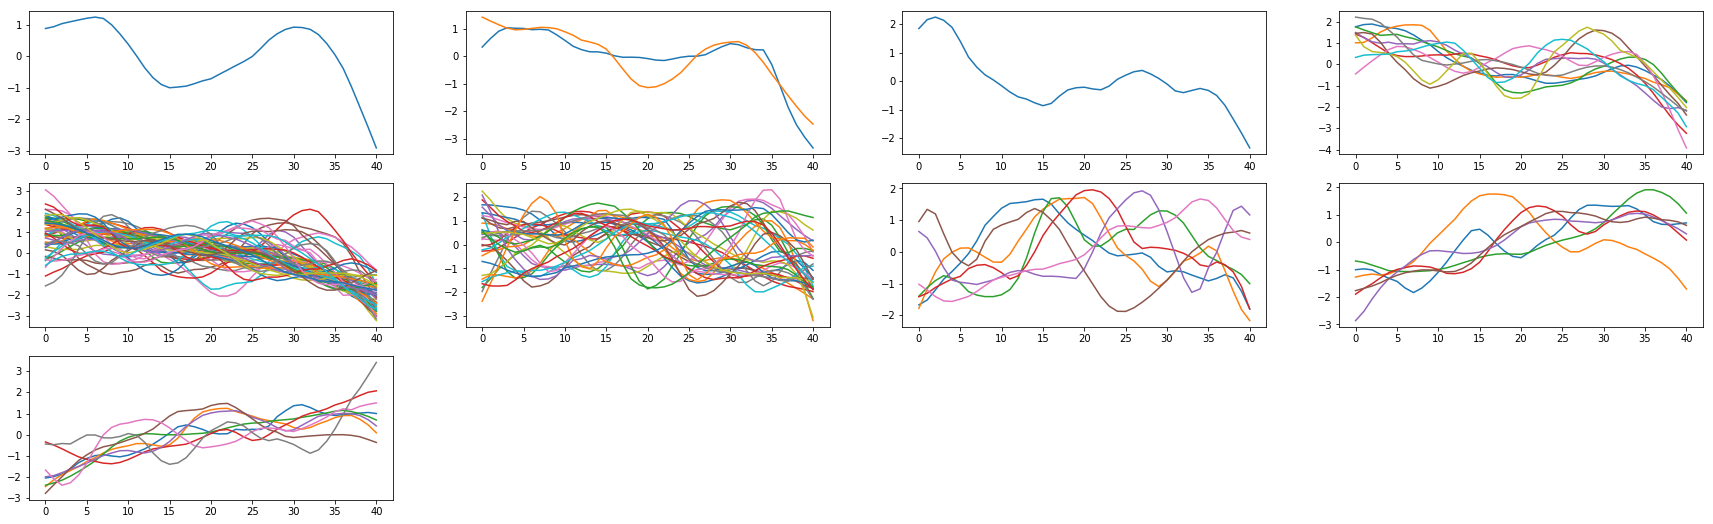

In [16]:
plt.figure(figsize=(30,len(Class)))
count = 1
for each_class in Class:
    index = []
    plt.subplot(len(Class)/4+1,4,count)
    for idx in each_class:
        x = range(len(mrcp_data[idx]))
        plt.plot(x,mrcp_data[idx])
        index.append(idx)
    #plt.xlabel('MRCP : '+str(index))
    count += 1
plt.show()

In [17]:
selected_mrcp_class = list()
removed_mrcp_class = list()
for e in Class:
    if len(e)>5: selected_mrcp_class.append(e)
    else: removed_mrcp_class.append(e)

mrcp_avg = []
for i in range(len(selected_mrcp_class)):
    l = []
    for e in selected_mrcp_class[i]:
        l.append(mrcp_data[e])
    mrcp_avg.append(performDBA(l))

l = list()
for i in range(len(removed_mrcp_class)):
    for e in removed_mrcp_class[i]:
        l.append(e)
l = np.array(l)
filtered_mrcp_data = np.delete(mrcp_data,l,axis=0)

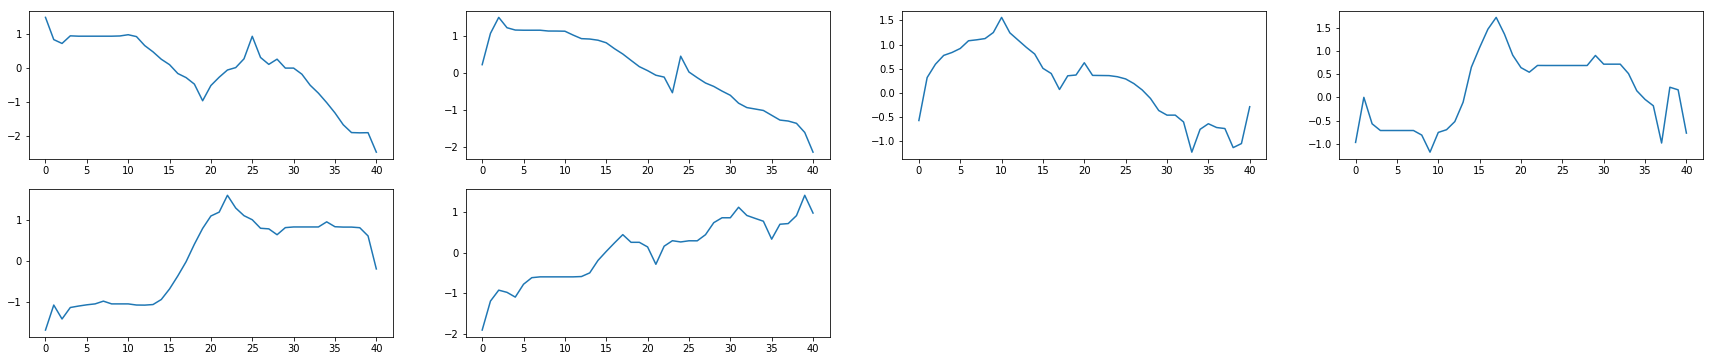

In [18]:
plt.figure(figsize=(30,len(mrcp_avg)))
count = 1
for each_class in mrcp_avg:
    plt.subplot(len(mrcp_avg)/4+1,4,count)
    x = range(len(each_class))
    plt.plot(x,each_class)
    count += 1
plt.show()

### Subclass Splitting II (Noise)

In [19]:
dist = []
for each_noise_data,idx in zip(noise_data,range(len(noise_data))):
    dist.append([np_euclidean(each_noise_data,noise_data[noise_pivot]),idx])

sorted_dist = sorted(dist,key=lambda x:x[0])
print('Sorted_Dist: ',sorted_dist[:5])

Sorted_Dist:  [[0.0, 61], [1.2280743229413253, 11], [1.88763229085459, 24], [2.140742074020948, 32], [2.1638598617559683, 69]]


In [20]:
diff = []
for i in range(1,len(sorted_dist)):
    diff.append(sorted_dist[i][0]-sorted_dist[i-1][0]);
diff = np.array(diff)
print('Diff: ',diff[:5])

Diff:  [1.22807432 0.65955797 0.25310978 0.02311779 0.08574592]


In [21]:
T_mean = math.fsum(diff)/len(diff)
T_std = math.sqrt(math.fsum((diff-T_mean)**2)/(len(diff)-1)) 
T = T_std/2
print('T: ',T)

T:  0.08120699849953586


In [22]:
Class = []
temp_c = []
temp_c.append(sorted_dist[0][1])
for i in range(len(diff)):
    if(diff[i] > T):
        Class.append(temp_c)
        temp_c = []
        temp_c.append(sorted_dist[i+1][1])
    else:
        temp_c.append(sorted_dist[i+1][1])

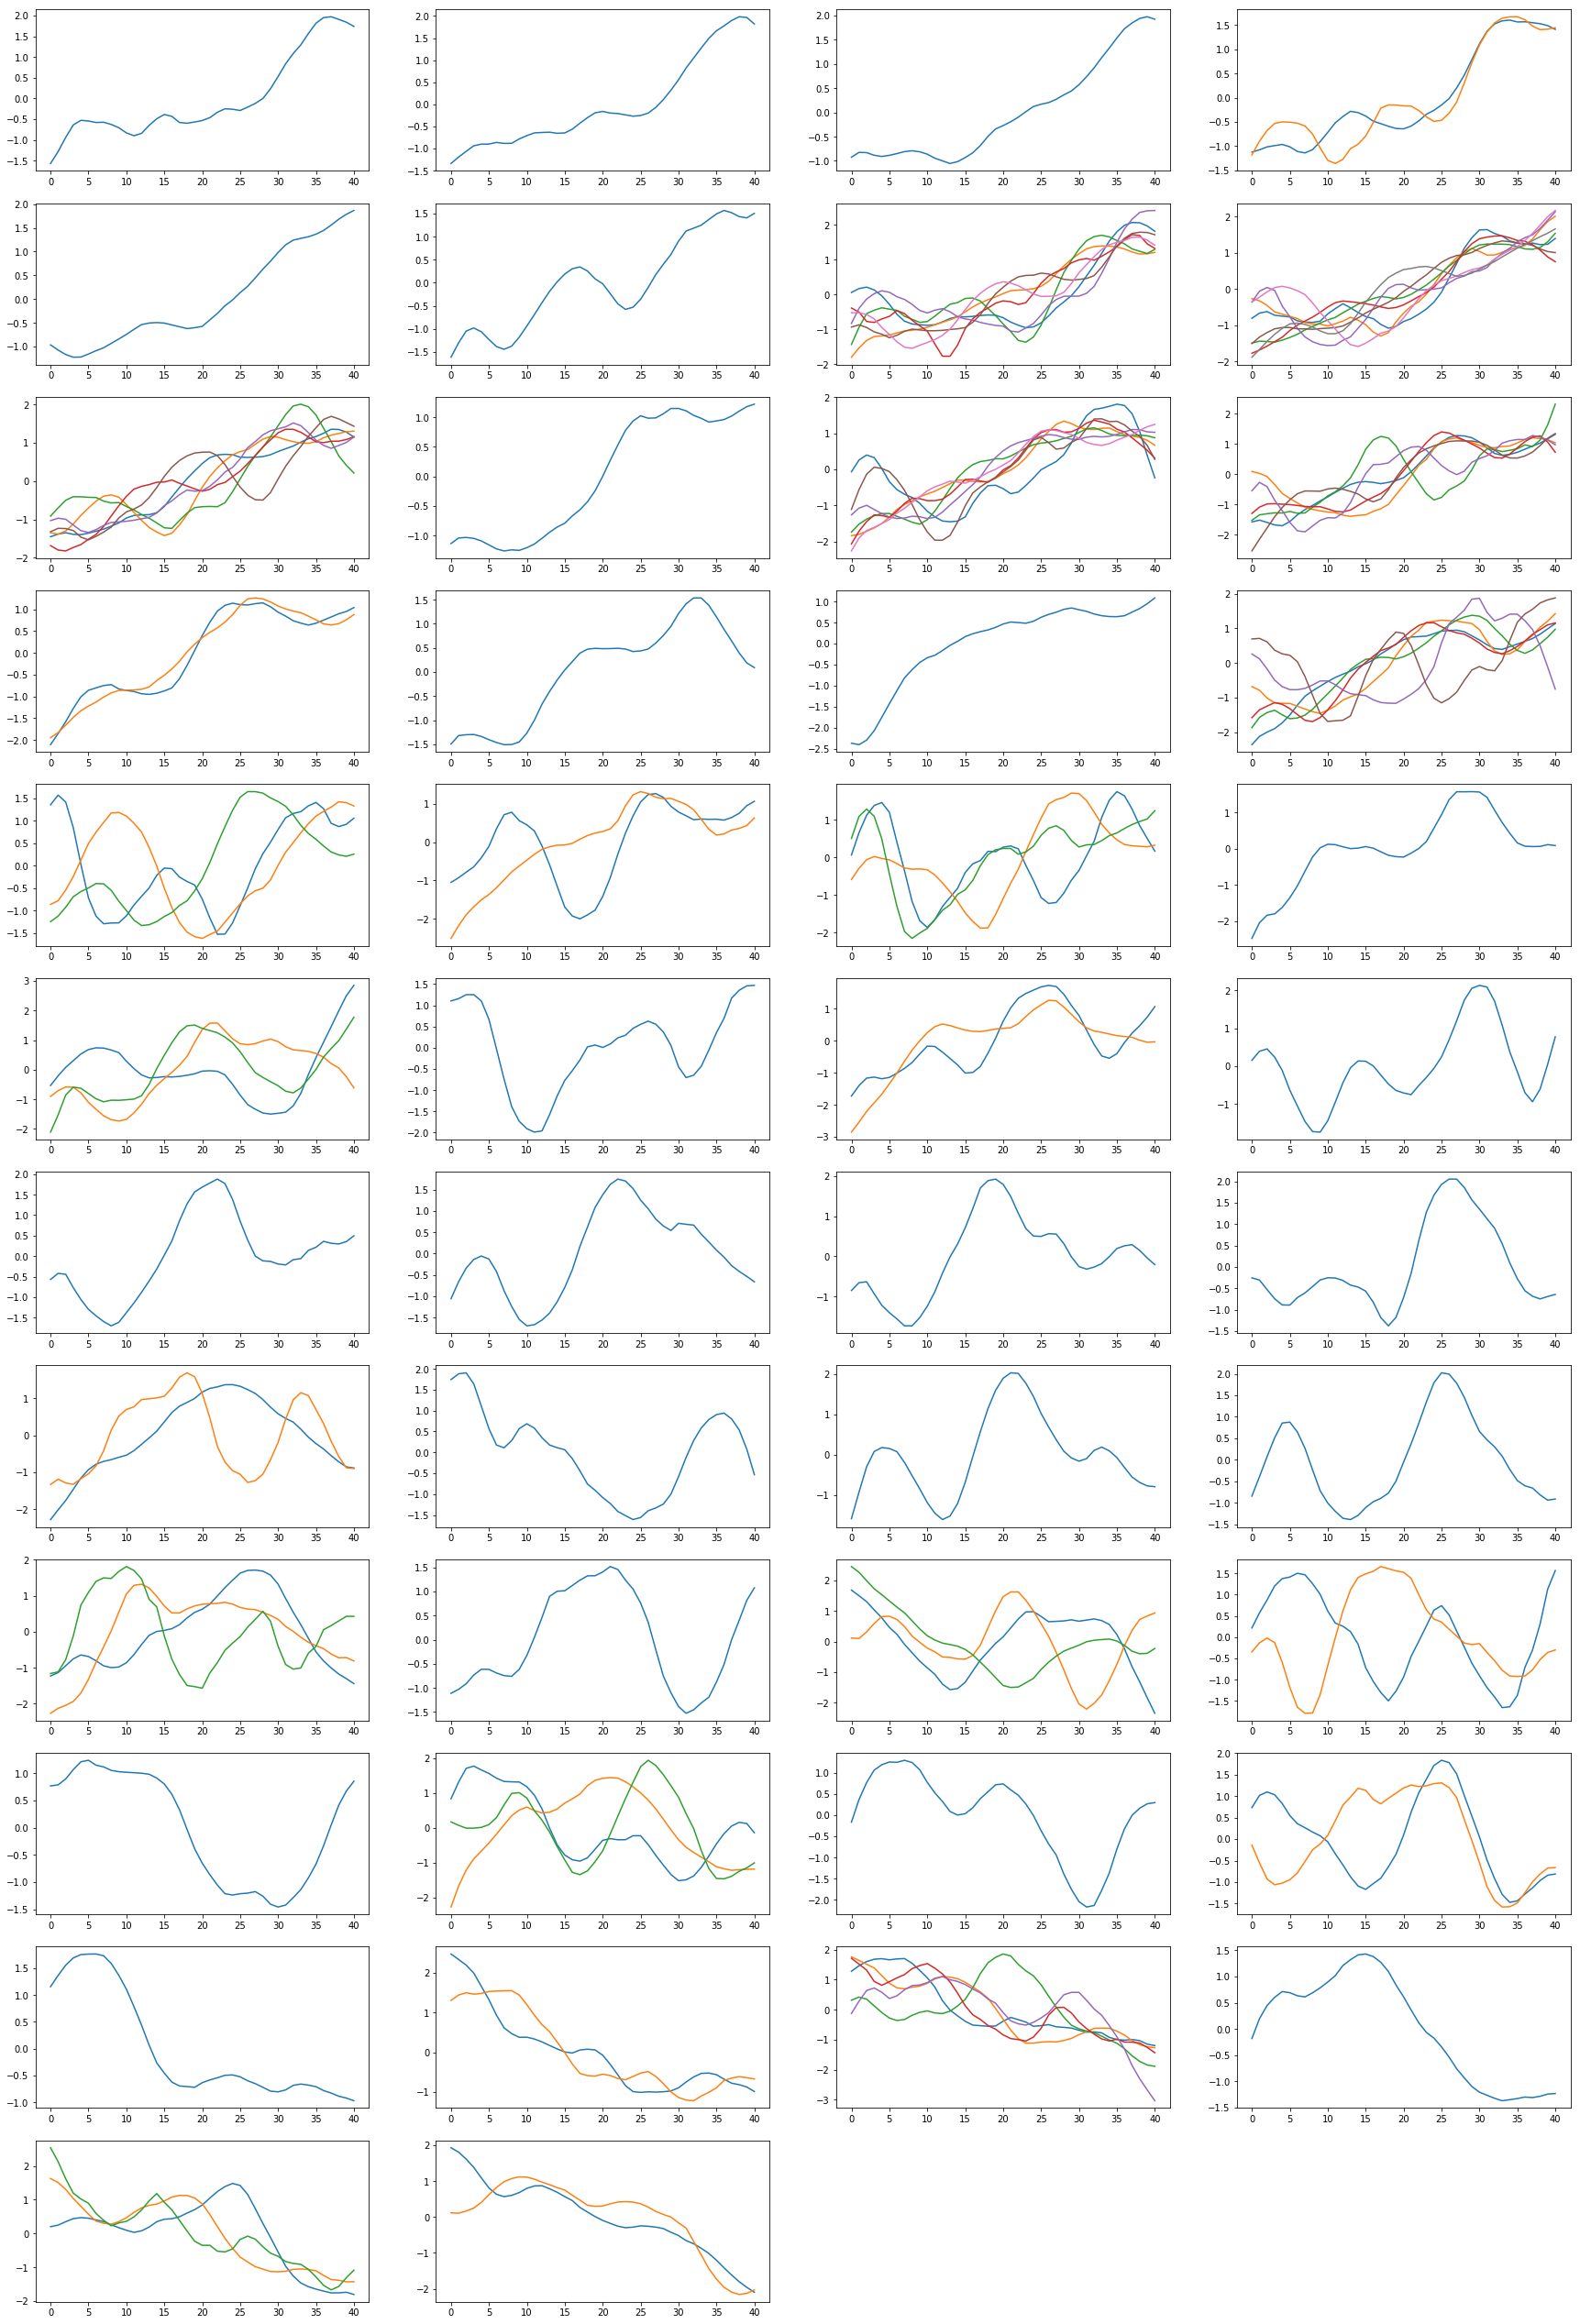

In [23]:
plt.figure(figsize=(30,len(Class)))
count = 1
for each_class in Class:
    index = []
    plt.subplot(len(Class)/4+1,4,count)
    for idx in each_class:
        x = range(len(noise_data[idx]))
        plt.plot(x,noise_data[idx])
        index.append(idx)
    #plt.xlabel('Noise : '+str(index))
    count += 1
plt.show()

In [24]:
selected_noise_class = list()
removed_noise_class = list()
for e in Class:
    if len(e)>5: selected_noise_class.append(e)
    else: removed_noise_class.append(e)

noise_avg = []
for i in range(len(selected_noise_class)):
    l = []
    for e in selected_noise_class[i]:
        l.append(noise_data[e])
    noise_avg.append(performDBA(l))

l = list()
for i in range(len(removed_noise_class)):
    for e in removed_noise_class[i]:
        l.append(e)
l = np.array(l)
filtered_noise_data = np.delete(noise_data,l,axis=0)

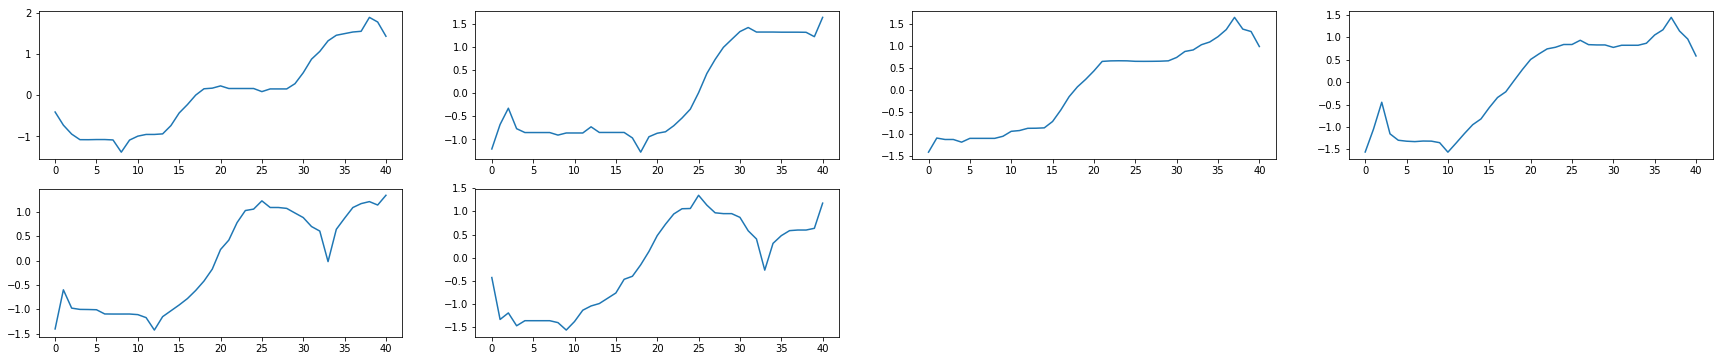

In [25]:
plt.figure(figsize=(30,len(noise_avg)))
count = 1
for each_class in noise_avg:
    plt.subplot(len(noise_avg)/4+1,4,count)
    x = range(len(each_class))
    plt.plot(x,each_class)
    count += 1
plt.show()

In [26]:
accuracy,f1_score = score(test_data,test_results,mrcp_avg,noise_avg);
print('Accuracy: ', accuracy, '\nF1_score: ', f1_score)

Accuracy:  68.37606837606837 
F1_score:  75.16778523489933


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

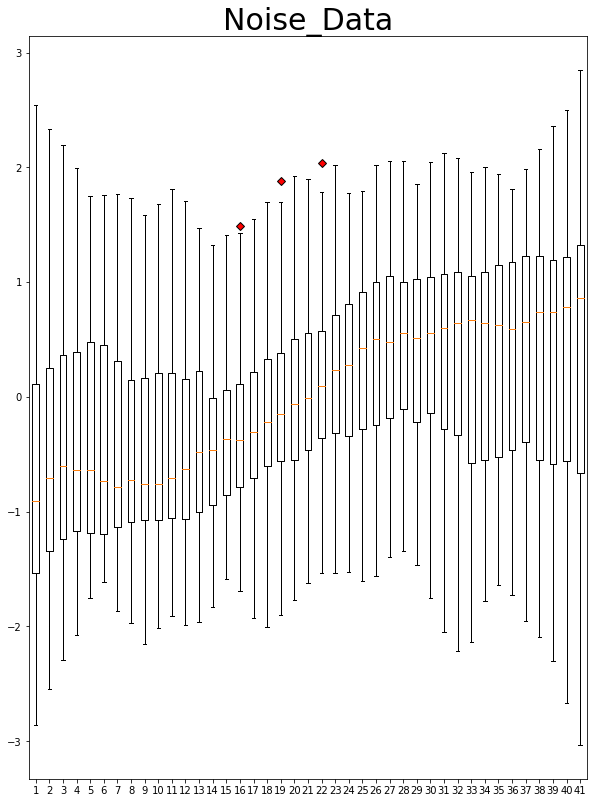

<Figure size 432x288 with 0 Axes>

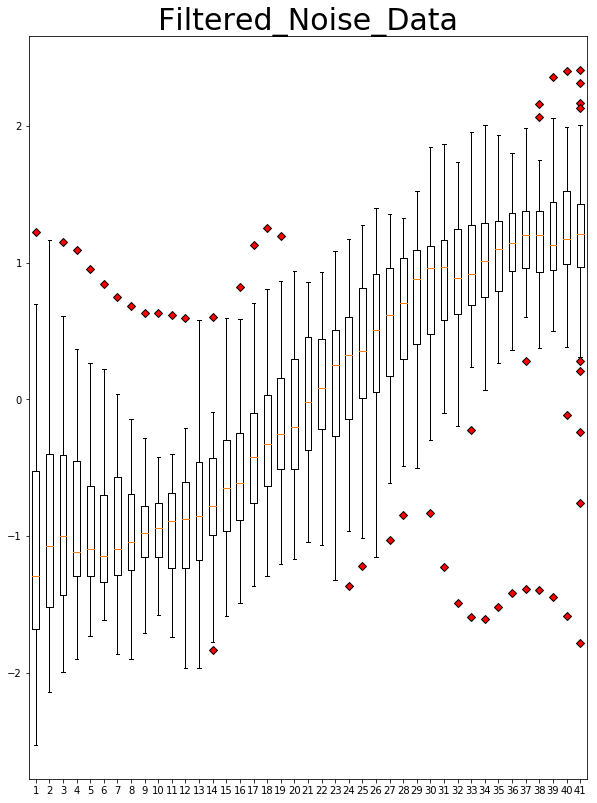

In [27]:
box_plot(noise_data,'Noise_Data')
box_plot(filtered_noise_data,'Filtered_Noise_Data')

ipynb.fs.full.BoxPlot:71: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Suphattarawanich.Top\Anaconda3\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\Suphattarawanich.Top\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

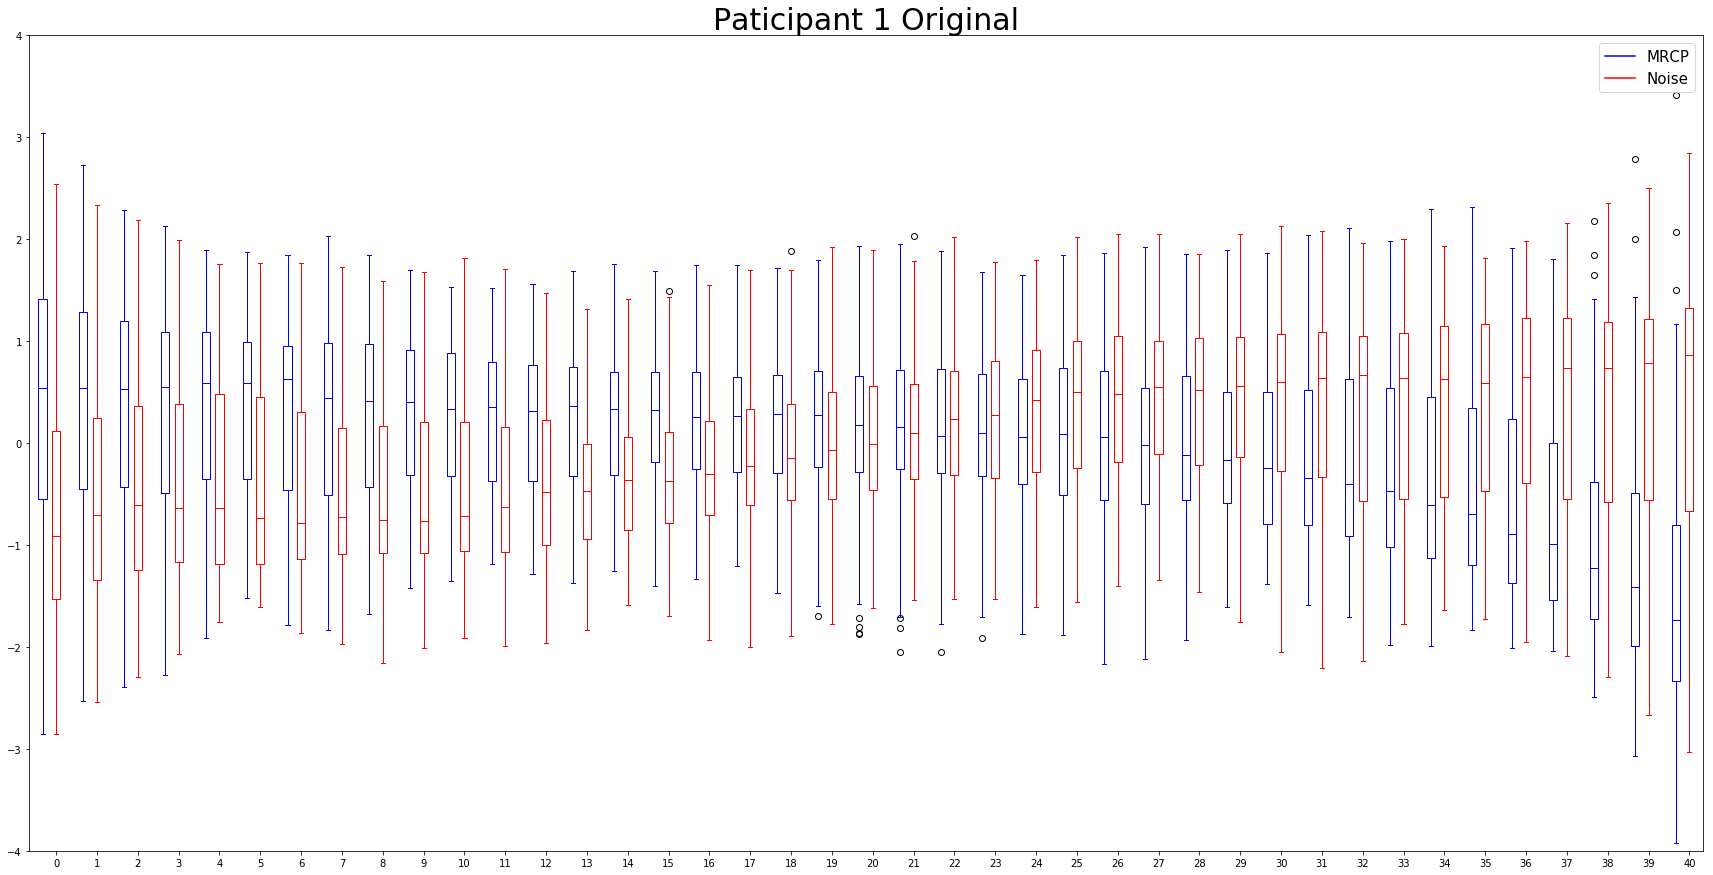

<Figure size 432x288 with 0 Axes>

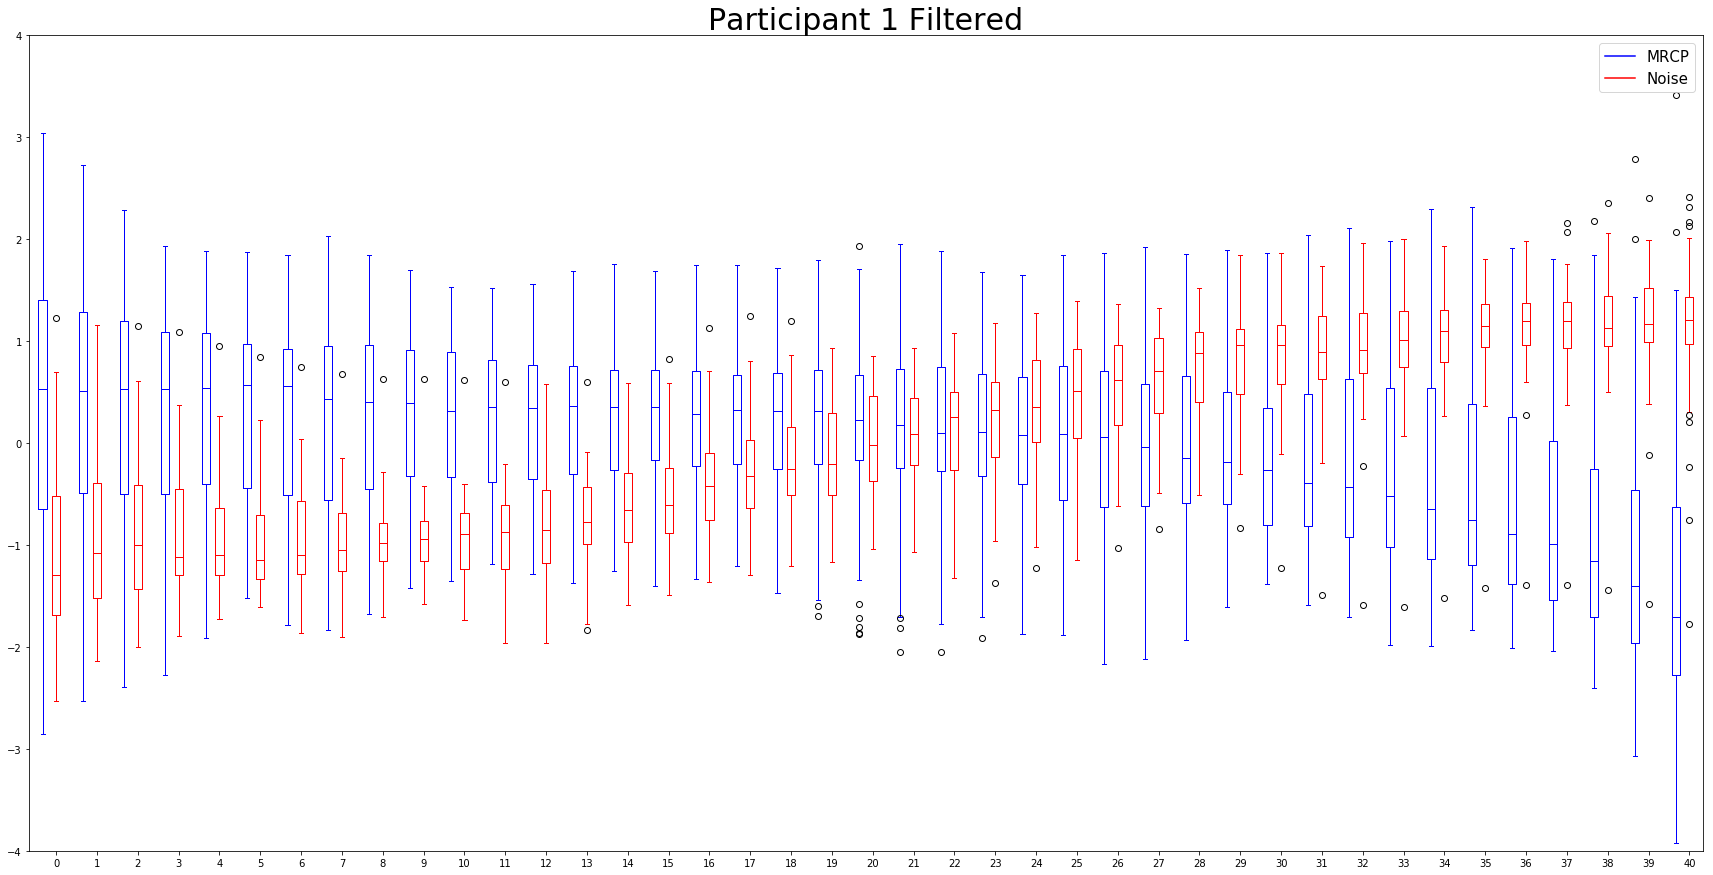

In [28]:
box_plot_compare(mrcp_data,noise_data,'Paticipant 1 Original')
box_plot_compare(filtered_mrcp_data,filtered_noise_data,'Participant 1 Filtered')